In [1]:
import torch

In [2]:

if torch.backends.mps.is_available():
    torch_device = torch.device("mps")
    x = torch.ones(1, device=torch_device)
    print (x)
else:
    torch_device = torch.device("cpu")
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## Module

In [3]:
import torch.nn as nn

EMBEDDING_DIM = 3
CONTEXT_LENGTH = 4
QKV_DIM = 2

class CausalSelfAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length=CONTEXT_LENGTH, dropout=0.5, qkv_bias=False):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.w_q = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_k = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_v = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.dropout = nn.Dropout(dropout).to(torch_device)
        self.register_buffer(
            'mask', 
            torch.triu(
                torch.ones(context_length, context_length), 
                diagonal=1,
            ).to(torch_device)
        )

    def forward(self, x):
        num_tokens = x.shape[-2]
        queries = self.w_q(x)
        keys = self.w_k(x)
        attn_scores = queries @ keys.transpose(-2, -1)
        causal_attn_scores = attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        causal_attn_weights = torch.softmax(causal_attn_scores*(self.d_out**0.5), dim=-1)
        causal_attn_weights = self.dropout(causal_attn_weights)
        values = self.w_v(x)
        context = causal_attn_weights @ values
        return context

In [4]:
import torch.nn as nn

EMBEDDING_DIM = 3
CONTEXT_LENGTH = 4
QKV_DIM = 2

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = d_out//num_heads
        self.w_q = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_k = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_v = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_o = nn.Linear(d_out, d_out).to(torch_device)
        # self.w_o = nn.Identity().to(torch_device)
        self.dropout = nn.Dropout(dropout).to(torch_device)
        self.register_buffer(
            'mask', 
            torch.triu(
                torch.ones(context_length, context_length), 
                diagonal=1,
            ).to(torch_device)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.w_k(x)
        queries = self.w_q(x)
        values = self.w_v(x)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(-3, -2)
        # TODO: KV Cache Optimization
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(-3, -2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(-3, -2)
        attn_scores = queries @ keys.transpose(-2, -1)
        causal_attn_scores = attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        causal_attn_weights = torch.softmax(causal_attn_scores/(keys.shape[-1]**0.5), dim=-1)
        causal_attn_weights = self.dropout(causal_attn_weights)
        context = (causal_attn_weights @ values).transpose(-3, -2)
        context = context.contiguous().view(b, num_tokens, self.num_heads*self.head_dim)
        context = self.w_o(context)
        return context

## Model

In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(d_model))
        self.shift = nn.Parameter(torch.zeros(d_model))

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True, unbiased=False)
        x = (self.scale * (x - mean) / (std + self.eps)) + self.shift
        return x


# class LayerNorm(nn.Module):
#     def __init__(self, emb_dim):
#         super().__init__()
#         self.eps = 1e-5
#         self.scale = nn.Parameter(torch.ones(emb_dim))
#         self.shift = nn.Parameter(torch.zeros(emb_dim))

#     def forward(self, x):
#         mean = x.mean(dim=-1, keepdim=True)
#         var = x.var(dim=-1, keepdim=True, unbiased=False)
#         norm_x = (x - mean) / torch.sqrt(var + self.eps)
#         return self.scale * norm_x + self.shift

In [7]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0/torch.pi, device=torch_device)) * (x  + 0.044715 * x**3)
            )
        )

In [8]:
class FeedForward (nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"]*4).to(torch_device),
            GELU().to(torch_device),
            nn.Linear(cfg["emb_dim"]*4, cfg["emb_dim"]).to(torch_device),
        )

    def forward(self, x):
        return self.layers(x)

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config["emb_dim"]).to(torch_device)
        self.attn = MultiHeadAttention(config["emb_dim"], config["emb_dim"], config["context_length"], config["drop_rate"], config["n_heads"], config["qkv_bias"]).to(torch_device)
        self.drop = nn.Dropout(config["drop_rate"]).to(torch_device)
        self.ln2 = LayerNorm(config["emb_dim"]).to(torch_device)
        self.ff = FeedForward(config).to(torch_device)

    def forward(self, x):
        x = self.drop(self.attn(self.ln1(x))) + x
        x = self.drop(self.ff(self.ln2(x))) + x
        return x



# class TransformerBlock(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.att = MultiHeadAttention(
#             d_in=cfg["emb_dim"],
#             d_out=cfg["emb_dim"],
#             context_length=cfg["context_length"],
#             num_heads=cfg["n_heads"],
#             dropout=cfg["drop_rate"],
#             qkv_bias=cfg["qkv_bias"])
#         self.ff = FeedForward(cfg)
#         self.norm1 = LayerNorm(cfg["emb_dim"])
#         self.norm2 = LayerNorm(cfg["emb_dim"])
#         self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

#     def forward(self, x):
#         # Shortcut connection for attention block
#         shortcut = x
#         x = self.norm1(x)
#         x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
#         x = self.drop_shortcut(x)
#         x = x + shortcut  # Add the original input back

#         # Shortcut connection for feed-forward block
#         shortcut = x
#         x = self.norm2(x)
#         x = self.ff(x)
#         x = self.drop_shortcut(x)
#         x = x + shortcut  # Add the original input back

#         return x

In [10]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]).to(torch_device)
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]).to(torch_device)
        self.drop_emb = nn.Dropout(cfg["drop_rate"]).to(torch_device)
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        ).to(torch_device)
        self.final_norm = LayerNorm(cfg["emb_dim"]).to(torch_device)
        # GPT2 uses tied weights for the embedding and output layers
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False).to(torch_device)

    def forward(self, in_idx):
        in_idx = in_idx.to(torch_device)
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=torch_device))
        x = self.drop_emb(tok_embeds + pos_embeds)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [11]:
# class MultiHeadAttention(nn.Module):
#     def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
#         super().__init__()
#         assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

#         self.d_out = d_out
#         self.num_heads = num_heads
#         self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

#         self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
#         self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
#         self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
#         self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
#         self.dropout = nn.Dropout(dropout)
#         self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

#     def forward(self, x):
#         b, num_tokens, d_in = x.shape

#         keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
#         queries = self.W_query(x)
#         values = self.W_value(x)

#         # We implicitly split the matrix by adding a `num_heads` dimension
#         # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
#         keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
#         values = values.view(b, num_tokens, self.num_heads, self.head_dim)
#         queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

#         # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
#         keys = keys.transpose(1, 2)
#         queries = queries.transpose(1, 2)
#         values = values.transpose(1, 2)

#         # Compute scaled dot-product attention (aka self-attention) with a causal mask
#         attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

#         # Original mask truncated to the number of tokens and converted to boolean
#         mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

#         # Use the mask to fill attention scores
#         attn_scores.masked_fill_(mask_bool, -torch.inf)

#         attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
#         attn_weights = self.dropout(attn_weights)

#         # Shape: (b, num_tokens, num_heads, head_dim)
#         context_vec = (attn_weights @ values).transpose(1, 2)

#         # Combine heads, where self.d_out = self.num_heads * self.head_dim
#         context_vec = context_vec.reshape(b, num_tokens, self.d_out)
#         context_vec = self.out_proj(context_vec)  # optional projection

#         return context_vec


# #####################################
# #Chapter 4
# #####################################
# class LayerNorm(nn.Module):
#     def __init__(self, emb_dim):
#         super().__init__()
#         self.eps = 1e-5
#         self.scale = nn.Parameter(torch.ones(emb_dim))
#         self.shift = nn.Parameter(torch.zeros(emb_dim))

#     def forward(self, x):
#         mean = x.mean(dim=-1, keepdim=True)
#         var = x.var(dim=-1, keepdim=True, unbiased=False)
#         norm_x = (x - mean) / torch.sqrt(var + self.eps)
#         return self.scale * norm_x + self.shift


# class GELU(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x):
#         return 0.5 * x * (1 + torch.tanh(
#             torch.sqrt(torch.tensor(2.0 / torch.pi)) *
#             (x + 0.044715 * torch.pow(x, 3))
#         ))


# class FeedForward(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
#             GELU(),
#             nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
#         )

#     def forward(self, x):
#         return self.layers(x)


# class TransformerBlock(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.att = MultiHeadAttention(
#             d_in=cfg["emb_dim"],
#             d_out=cfg["emb_dim"],
#             context_length=cfg["context_length"],
#             num_heads=cfg["n_heads"],
#             dropout=cfg["drop_rate"],
#             qkv_bias=cfg["qkv_bias"])
#         self.ff = FeedForward(cfg)
#         self.norm1 = LayerNorm(cfg["emb_dim"])
#         self.norm2 = LayerNorm(cfg["emb_dim"])
#         self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

#     def forward(self, x):
#         # Shortcut connection for attention block
#         shortcut = x
#         x = self.norm1(x)
#         x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
#         x = self.drop_shortcut(x)
#         x = x + shortcut  # Add the original input back

#         # Shortcut connection for feed-forward block
#         shortcut = x
#         x = self.norm2(x)
#         x = self.ff(x)
#         x = self.drop_shortcut(x)
#         x = x + shortcut  # Add the original input back

#         return x


# class GPTModel(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
#         self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
#         self.drop_emb = nn.Dropout(cfg["drop_rate"])

#         self.trf_blocks = nn.Sequential(
#             *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

#         self.final_norm = LayerNorm(cfg["emb_dim"])
#         self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

#     def forward(self, in_idx):
#         batch_size, seq_len = in_idx.shape
#         tok_embeds = self.tok_emb(in_idx)
#         pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
#         x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
#         x = self.drop_emb(x)
#         x = self.trf_blocks(x)
#         x = self.final_norm(x)
#         logits = self.out_head(x)
#         return logits

In [12]:
def generate_text_simple(model, token_ids, max_new_tokens, context_size):
    logits = None
    for i in range(max_new_tokens):
        context_token_ids = token_ids[:, -context_size:]
        with torch.no_grad():
            logits = model(context_token_ids)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        token_id_next = torch.argmax(probas, dim=1, keepdim=True)  # Pure Greed
        token_ids = torch.cat((token_ids, token_id_next), dim=1) 

    return token_ids

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special=set(['<|endoftext|>']))
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(torch_device)
    return encoded_tensor

In [13]:
def loss_fn(logits, targets):
    vocab_size = logits.shape[-1]
    loss = nn.CrossEntropyLoss()(logits.view(-1, vocab_size), targets.view(-1))
    return loss

In [14]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
tokenizer = tiktoken.get_encoding("gpt2")

class GPTDatasetV1(Dataset):
#     def __init__(self, txt, tokenizer, max_length, stride):
#         self.input_ids = []
#         self.target_ids = []
#         token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
#         token_ids = token_ids
#         token_ids = torch.tensor(token_ids).to(torch_device)
#         print(token_ids.shape)
#         token_sequences = token_ids.unfold(0, max_length, stride)
#         self.input_ids = token_sequences[:-1]
#         self.target_ids = token_sequences[1:]

    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(
        txt, batch_size=4, max_length=256, 
        stride=128, shuffle=True, drop_last=True,
        num_workers=0,
    ):
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
        drop_last=drop_last,
    )

In [15]:
def calc_loss_batch(input_batch, target_batch, model, device=torch_device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.view(-1, logits.shape[-1]), 
        target_batch.view(-1),
    )
    return loss

In [16]:
def calc_loss_loader(dataloader, model, device, num_batches=None):
    total_loss = 0
    if len(dataloader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

## Train

In [17]:
def evaluate_model(model, train_dataloader, test_dataloader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_dataloader, model, device, num_batches=eval_iter)
        test_loss = calc_loss_loader(test_dataloader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, test_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    token_ids = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, token_ids, 50, context_size)
    decoded_text = tokenizer.decode(token_ids[0].tolist())
    print(decoded_text.replace("\n", " "))
    model.train()

In [18]:
def train_model_simple(
    model, train_dataloader, test_dataloader,
    optimizer, device, num_epochs,
    eval_freq, eval_iter, start_context, tokenizer
):
    train_losses, test_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_dataloader:
            optimizer.zero_grad()
            # print(input_batch)
            # print(target_batch)
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            # grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # print(f"Gradient norm: {grad_norm:.4f}")
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step %eval_freq == 0:
                train_loss, test_loss = evaluate_model(
                    model, train_dataloader, test_dataloader, device, eval_iter
                )
                train_losses.append(train_loss)-
                test_losses.append(test_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Epoch {epoch + 1} (Step {global_step:06d}): "
                    f"Train Loss: {train_loss:.3f}, "
                    f"Val Loss: {test_loss:.3f}"
                )

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, test_losses, track_tokens_seen


In [19]:
with open("../data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

train_ratio = 0.9
split_idx = int(len(raw_text) * train_ratio)
train_data = raw_text[:split_idx]
test_data = raw_text[split_idx:]

torch.manual_seed(123)
train_dataloader = create_dataloader_v1(train_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], shuffle=True)
test_dataloader = create_dataloader_v1(test_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], shuffle=False)

In [20]:
# train_data[:100], test_data[:100]
# tokenizer = tiktoken.get_encoding("gpt2")
# tokenizer.encode(train_data[:100], allowed_special={"<|endoftext|>"})
# len(train_dataloader), len(test_dataloader)
# input_sample, target_sample = next(iter(train_dataloader))
# torch.sum(input_sample[1]), torch.sum(target_sample[1])
# input_sample.shape, 
# input_sample[1],target_sample[1]

In [21]:
torch.manual_seed(123)
gpt = GPTModel(GPT_CONFIG_124M).to(torch_device)
optimizer = torch.optim.AdamW(
    gpt.parameters(),
    lr = 0.0004, weight_decay = 0.1
)
num_epochs = 10

In [22]:
train_losses, test_losses, track_tokens_seen = train_model_simple(
    gpt, train_dataloader, test_dataloader, optimizer, torch_device,
    num_epochs, eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer,
)

Epoch 1 (Step 000000): Train Loss: 9.817, Val Loss: 9.924
Epoch 1 (Step 000005): Train Loss: 8.066, Val Loss: 8.332
Every effort moves you,,,,,,,,,,,,.                                     
Epoch 2 (Step 000010): Train Loss: 6.619, Val Loss: 7.042
Epoch 2 (Step 000015): Train Loss: 6.046, Val Loss: 6.596
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Epoch 3 (Step 000020): Train Loss: 5.524, Val Loss: 6.508
Epoch 3 (Step 000025): Train Loss: 5.369, Val Loss: 6.378
Every effort moves you, and to the of the of the picture. Gis.                                     
Epoch 4 (Step 000030): Train Loss: 4.830, Val Loss: 6.263
Epoch 4 (Step 000035): Train Loss: 4.586, Val Loss: 6.285
Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been the picture of
Epoch 5 (Step 000040): Train Loss: 3.880, Val Loss: 6.130
Every effort moves you know he had been his pictures

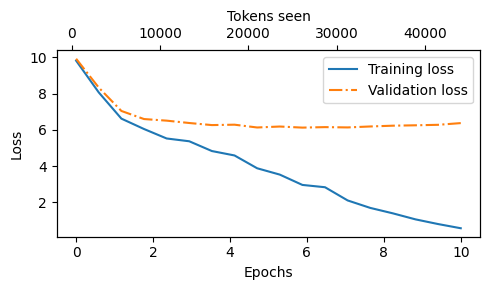

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, test_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, test_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, test_losses)

In [24]:
gpt

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm()
      (attn): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=False)
        (w_k): Linear(in_features=768, out_features=768, bias=False)
        (w_v): Linear(in_features=768, out_features=768, bias=False)
        (w_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (drop): Dropout(p=0.1, inplace=False)
      (ln2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (ln1): LayerNorm()
      (attn): MultiHeadAttention(
        (w_q): Linear(in_features=768,